In [1]:
"""
Import necessary libraries and define paths to data files.

Imports:
    numpy as np: Library for numerical computations.
    pandas as pd: Library for data manipulation and analysis.
    matplotlib.pyplot as plt: Library for data visualization.
    torch: PyTorch library for deep learning.
    sklearn.preprocessing.MinMaxScaler: Class for scaling numerical features to a specified range.
    copy.deepcopy: Function to create a deep copy of objects.
    
Global Variables:
    device (str): Indicates whether the code will run on CPU or GPU.
    train_data_path (str): Path to the CSV file containing training data.
    test_data_path (str): Path to the CSV file containing test data.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler

from copy import deepcopy

from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

train_data_path = '/home/girikk/FedGRU/data/train.csv'
test_data_path = '/home/girikk/FedGRU/data/test.csv'


### Implementation of GRU

In [2]:
"""
Load data from CSV files and extract a specific column.

Parameters:
    train_data_path (str): Path to the CSV file containing training data.
    test_data_path (str): Path to the CSV file containing test data.
    attr (str): Name of the column to extract from the CSV files.

Returns:
    pd.Series: Pandas Series containing the specified column from the training data.
    pd.Series: Pandas Series containing the specified column from the test data.
"""

attr = 'Lane 1 Flow (Veh/5 Minutes)'

train_data = pd.read_csv(train_data_path)[attr]
test_data = pd.read_csv(test_data_path)[attr]

In [3]:
train_data, test_data

(0       12
 1       13
 2       11
 3       13
 4       10
         ..
 7771    19
 7772     6
 7773    14
 7774    11
 7775    10
 Name: Lane 1 Flow (Veh/5 Minutes), Length: 7776, dtype: int64,
 0       16
 1       10
 2       11
 3       11
 4        6
         ..
 4315    23
 4316    21
 4317    21
 4318    23
 4319    14
 Name: Lane 1 Flow (Veh/5 Minutes), Length: 4320, dtype: int64)

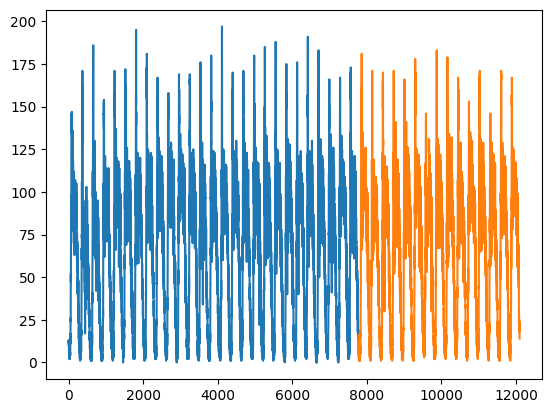

In [4]:
"""
Plot the training and test data.

Parameters:
    train_data (pd.Series): Pandas Series containing the training data.
    test_data (pd.Series): Pandas Series containing the test data.
"""

plt.plot([x for x in range(len(train_data))], train_data)
plt.plot([x for x in range(len(train_data), len(train_data) + len(test_data))], test_data)

In [5]:
def prepare_dataframe_for_GRU(dataf, lag):
    """
    Prepare dataframe for input to a GRU model by adding lagged features.

    Parameters:
        dataf (pd.DataFrame): Original dataframe containing the data.
        lag (int): Number of lagged time steps to add as features.

    Returns:
        pd.DataFrame: Dataframe with lagged features added.
    """
    temp = dataf.copy()
    
    for i in range(1, lag+1):
        temp[f'attr(t-{i})'] = temp[attr].shift(i)

    temp.dropna(inplace=True)

    return temp

# Define lag for adding lagged features
lag = 12

# Prepare shifted training and test dataframes
shifted_train_data = prepare_dataframe_for_GRU(pd.DataFrame(train_data), lag)
shifted_test_data = prepare_dataframe_for_GRU(pd.DataFrame(test_data), lag)

# Display the resulting shifted training and test dataframes
shifted_train_data, shifted_test_data

(      Lane 1 Flow (Veh/5 Minutes)  attr(t-1)  attr(t-2)  attr(t-3)  attr(t-4)  \
 12                              8        8.0        7.0        6.0       10.0   
 13                             12        8.0        8.0        7.0        6.0   
 14                              7       12.0        8.0        8.0        7.0   
 15                              5        7.0       12.0        8.0        8.0   
 16                              2        5.0        7.0       12.0        8.0   
 ...                           ...        ...        ...        ...        ...   
 7771                           19       13.0       17.0       19.0       13.0   
 7772                            6       19.0       13.0       17.0       19.0   
 7773                           14        6.0       19.0       13.0       17.0   
 7774                           11       14.0        6.0       19.0       13.0   
 7775                           10       11.0       14.0        6.0       19.0   
 
       attr(t-

In [6]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the training data and fit the scaler
shifted_train_data_normal = scaler.fit_transform(shifted_train_data)

# Scale the test data using the scaler fitted on training data
shifted_test_data_normal = scaler.transform(shifted_test_data)

# Display the scaled training and test data
shifted_train_data_normal, shifted_test_data_normal


(array([[-0.91878173, -0.91878173, -0.92893401, ..., -0.88832487,
         -0.8680203 , -0.87817259],
        [-0.87817259, -0.91878173, -0.91878173, ..., -0.8680203 ,
         -0.88832487, -0.8680203 ],
        [-0.92893401, -0.87817259, -0.91878173, ..., -0.89847716,
         -0.8680203 , -0.88832487],
        ...,
        [-0.85786802, -0.93908629, -0.8071066 , ..., -0.78680203,
         -0.72588832, -0.83756345],
        [-0.88832487, -0.85786802, -0.93908629, ..., -0.79695431,
         -0.78680203, -0.72588832],
        [-0.89847716, -0.88832487, -0.85786802, ..., -0.88832487,
         -0.79695431, -0.78680203]]),
 array([[-0.87817259, -0.92893401, -0.95939086, ..., -0.88832487,
         -0.89847716, -0.83756345],
        [-0.94923858, -0.87817259, -0.92893401, ..., -0.88832487,
         -0.88832487, -0.89847716],
        [-0.89847716, -0.94923858, -0.87817259, ..., -0.93908629,
         -0.88832487, -0.88832487],
        ...,
        [-0.78680203, -0.78680203, -0.76649746, ..., -

In [7]:
# Extract features and target variables from scaled training and test data
X_train = shifted_train_data_normal[:, 1:]  # Features are all columns except the first one
y_train = shifted_train_data_normal[:, 0]   # Target variable is the first column

X_test = shifted_test_data_normal[:, 1:]   # Features are all columns except the first one
y_test = shifted_test_data_normal[:, 0]    # Target variable is the first column

# Display the shapes of the extracted features and target variables
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((7764, 12), (7764,), (4308, 12), (4308,))

In [8]:
# Flip the order of features along the time axis for both training and test data
X_train = deepcopy(np.flip(X_train, axis=1))
X_test = deepcopy(np.flip(X_test, axis=1))

# Display the flipped training and test data
X_train, X_test


(array([[-0.87817259, -0.8680203 , -0.88832487, ..., -0.93908629,
         -0.92893401, -0.91878173],
        [-0.8680203 , -0.88832487, -0.8680203 , ..., -0.92893401,
         -0.91878173, -0.91878173],
        [-0.88832487, -0.8680203 , -0.89847716, ..., -0.91878173,
         -0.91878173, -0.87817259],
        ...,
        [-0.83756345, -0.72588832, -0.78680203, ..., -0.8680203 ,
         -0.8071066 , -0.93908629],
        [-0.72588832, -0.78680203, -0.79695431, ..., -0.8071066 ,
         -0.93908629, -0.85786802],
        [-0.78680203, -0.79695431, -0.88832487, ..., -0.93908629,
         -0.85786802, -0.88832487]]),
 array([[-0.83756345, -0.89847716, -0.88832487, ..., -0.92893401,
         -0.95939086, -0.92893401],
        [-0.89847716, -0.88832487, -0.88832487, ..., -0.95939086,
         -0.92893401, -0.87817259],
        [-0.88832487, -0.88832487, -0.93908629, ..., -0.92893401,
         -0.87817259, -0.94923858],
        ...,
        [-0.70558376, -0.73604061, -0.72588832, ..., -

In [9]:
# Reshape the training and test data to match the input shape of the GRU model
X_train = X_train.reshape(-1, lag, 1)
X_test = X_test.reshape(-1, lag, 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Display the shapes of the reshaped training and test data
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((7764, 12, 1), (7764, 1), (4308, 12, 1), (4308, 1))

In [10]:
# Convert the numpy arrays to PyTorch tensors and specify the data type as float32
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Display the shapes of the PyTorch tensors
X_train.shape, y_train.shape, X_test.shape, y_test.shape


(torch.Size([7764, 12, 1]),
 torch.Size([7764, 1]),
 torch.Size([4308, 12, 1]),
 torch.Size([4308, 1]))

In [11]:
class TimeSeriesData(Dataset):
    """Custom PyTorch dataset for time series data."""

    def __init__(self, X, y):
        """
        Initialize the TimeSeriesData dataset.

        Args:
            X (torch.Tensor): Input features.
            y (torch.Tensor): Target labels.
        """
        self.X = X  # Input features
        self.y = y  # Target labels

    def __len__(self):
        """Return the length of the dataset."""
        return len(self.X)

    def __getitem__(self, idx):
        """
        Retrieve a sample from the dataset at the specified index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the input features and target label.
        """
        return self.X[idx], self.y[idx]

# Create instances of TimeSeriesData for the training and test datasets
train_dataset = TimeSeriesData(X_train, y_train)
test_dataset = TimeSeriesData(X_test, y_test)


In [12]:
# Set the batch size for data loaders
batch_size = 256

# Create data loaders for training and testing datasets
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
# Iterate over batches of data in the train_data_loader
for _, (X_batch, y_batch) in enumerate(train_data_loader):
    # Print the shapes of the input and target tensors for the first batch
    print("Input shape:", X_batch.shape)
    print("Target shape:", y_batch.shape)
    break  # Exit the loop after printing the first batch


Input shape: torch.Size([256, 12, 1])
Target shape: torch.Size([256, 1])


In [14]:
input_num, hidden_num, output_num, num_layers = lag, 100, 1, 2  # Define the input, hidden, and output dimensions

class GRU(nn.Module):
    def __init__(self, input_num, hidden_num, output_num, num_layers=1):
        super(GRU, self).__init__()
        self.hidden_size = hidden_num
        self.num_layers = num_layers
        
        # Define a list to store multiple GRU layers
        self.gru_layers = nn.ModuleList([nn.GRU(input_size=input_num if i == 0 else hidden_num,
                                                hidden_size=hidden_num,
                                                batch_first=True) for i in range(num_layers)])
        
        # Define the output linear layer
        self.output_linear = nn.Linear(hidden_num, output_num)
        self.hidden = None  # Initialize hidden state to None

    def forward(self, x):
        x = x.view(x.shape[0], -1, x.shape[1])  # Reshape input tensor
        x = x.float()  # Convert input to float
        
        for layer in self.gru_layers:
            x, self.hidden = layer(x)  # Pass input through each GRU layer
         
        x = self.output_linear(x)  # Pass GRU output through linear layer
        return x, self.hidden  # Return output and hidden state


# Instantiate the GRU model and move it to the appropriate device (CPU or GPU)
global_model = GRU(input_num, hidden_num, output_num, num_layers).to(device)
global_model  # Print the model architecture


GRU(
  (gru_layers): ModuleList(
    (0): GRU(12, 100, batch_first=True)
    (1): GRU(100, 100, batch_first=True)
  )
  (output_linear): Linear(in_features=100, out_features=1, bias=True)
)

In [15]:
summary(global_model, input=((batch_size, lag, 1)))

Layer (type:depth-idx)                   Param #
GRU                                      --
├─ModuleList: 1-1                        --
│    └─GRU: 2-1                          34,200
│    └─GRU: 2-2                          60,600
├─Linear: 1-2                            101
Total params: 94,901
Trainable params: 94,901
Non-trainable params: 0

In [16]:
# Iterate over batches in the training data loader
for batch_idx, (X_batch, y_batch) in enumerate(train_data_loader):
    # Move the batch data to the appropriate device (CPU or GPU)
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    
    # Print the shape of input batch and target batch
    print("Input Batch Shape:", X_batch.shape)
    print("Target Batch Shape:", y_batch.shape)
    
    # Pass the input batch through the global model to get predictions
    output, _ = global_model(X_batch)
    
    # Print the output shape from the global model
    print("Output Batch Shape:", output.shape)
    
    # Break after processing the first batch
    break


Input Batch Shape: torch.Size([256, 12, 1])
Target Batch Shape: torch.Size([256, 1])
Output Batch Shape: torch.Size([256, 1, 1])


Epoch 1
Batch 10 Loss: 0.23153034299612046
Batch 20 Loss: 0.06551029607653618
Batch 30 Loss: 0.04632953591644764
Average Test Loss: 0.028365632847828025
*********************************************
Epoch 2
Batch 10 Loss: 0.02964036203920841
Batch 20 Loss: 0.023668598756194113
Batch 30 Loss: 0.019180767983198167
Average Test Loss: 0.018837958081241918
*********************************************
Epoch 3
Batch 10 Loss: 0.018532519601285456
Batch 20 Loss: 0.017732479609549046
Batch 30 Loss: 0.014573955815285445
Average Test Loss: 0.01411507831995978
*********************************************
Epoch 4
Batch 10 Loss: 0.01380499778315425
Batch 20 Loss: 0.012467860896140336
Batch 30 Loss: 0.01242613811045885
Average Test Loss: 0.011591785423019352
*********************************************
Epoch 5
Batch 10 Loss: 0.011705136392265558
Batch 20 Loss: 0.011267676576972007
Batch 30 Loss: 0.011184565350413322
Average Test Loss: 0.01107947007917306
********************************************

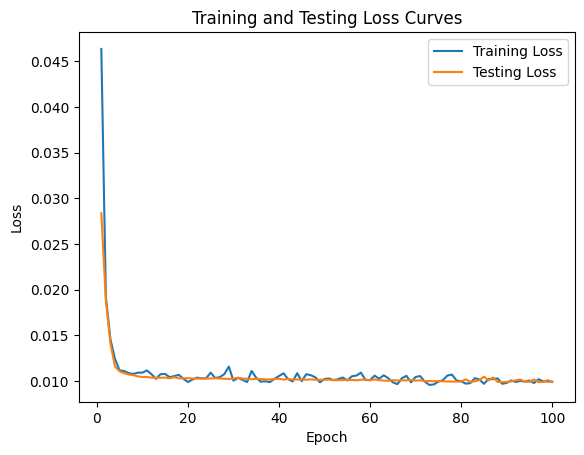

In [17]:
# Set hyperparameters
learning_rate = 0.001
num_epochs = 100

# Define loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(global_model.parameters(), lr=learning_rate)
# Alternatively, you can use SGD optimizer with momentum:
# optimizer = torch.optim.SGD(global_model.parameters(), lr=learning_rate)

train_losses = []  # List to store training losses for each epoch
test_losses = []   # List to store testing losses for each epoch

# Iterate over epochs
for epoch in range(num_epochs):
    
    global_model.train()  # Set model to training mode
    print(f"Epoch {epoch+1}")
    
    running_loss = 0
    
    # Iterate over batches in the training data loader
    for batch_idx, (X_batch, y_batch) in enumerate(train_data_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        output, _ = global_model(X_batch)
        output = output.squeeze(1)
        
        # Compute loss
        loss = loss_function(output, y_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx % 10 == 9:
            avg_loss_per_batch = running_loss / 10
            print(f"Batch {batch_idx+1} Loss: {avg_loss_per_batch}")
            running_loss = 0  # Reset running loss
            
    train_losses.append(avg_loss_per_batch)  # Append training loss for the epoch
        
    # Evaluation on the test set
    global_model.eval()  # Set model to evaluation mode
    running_test_loss = 0
    
    with torch.no_grad():
        # Iterate over batches in the test data loader
        for batch_idx, (X_batch, y_batch) in enumerate(test_data_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output, _ = global_model(X_batch)
            output = output.squeeze(1)
            loss = loss_function(output, y_batch)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_data_loader)
    print(f"Average Test Loss: {avg_test_loss}")
    print("*********************************************")
    
    test_losses.append(avg_test_loss)  # Append testing loss for the epoch

# Plot the loss curves
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')
plt.legend()
plt.show()


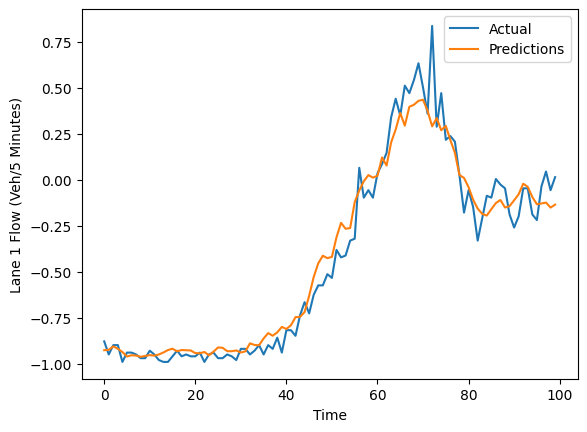

In [18]:
# Define the number of data points to plot from the first one
k = 100

# Make predictions on the training data
with torch.no_grad():
    train_predictions = global_model(X_train.to(device))[0].cpu().numpy()

# Plot actual and predicted values for the first k data points
plt.plot(y_test[:k], label="Actual")
plt.plot(train_predictions.squeeze()[:k], label='Predictions')
plt.xlabel('Time')
plt.ylabel('Lane 1 Flow (Veh/5 Minutes)')
plt.legend()
plt.show()


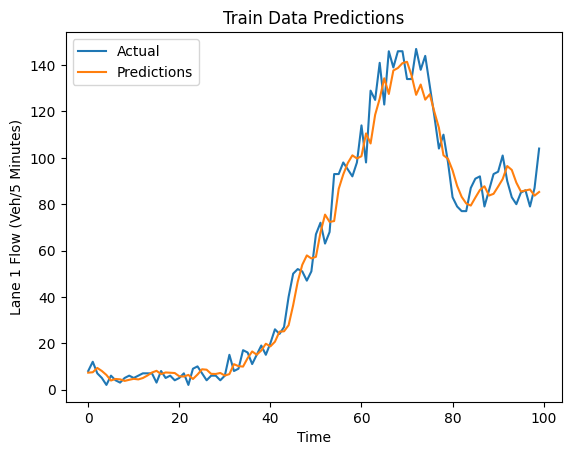

In [19]:
# Flatten the train_predictions array
train_predictions_normal = train_predictions.flatten()

# Create dummy arrays for inverse scaling
dummies = np.zeros((X_train.shape[0], lag+1))
dummies[:,0] = train_predictions_normal

# Inverse transform the scaled predictions to get back to the original scale
dummies = scaler.inverse_transform(dummies)
train_predictions_normal = deepcopy(dummies[:,0])

# Create dummy arrays for inverse scaling of original data
dummies = np.zeros((X_train.shape[0], lag+1))
dummies[:,0] = y_train.flatten()

# Inverse transform the scaled original data to get back to the original scale
dummies = scaler.inverse_transform(dummies)
train_original_normal = deepcopy(dummies[:,0])

# Plot actual and predicted values for the first k data points
plt.plot(train_original_normal[:k], label="Actual")
plt.plot(train_predictions_normal.squeeze()[:k], label='Predictions')
plt.title('Train Data Predictions')
plt.xlabel('Time')
plt.ylabel('Lane 1 Flow (Veh/5 Minutes)')
plt.legend()
plt.show()


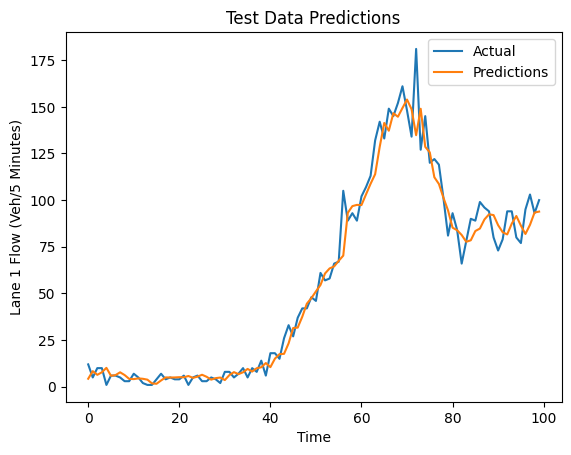

In [20]:
# Get predictions on the test data
test_predictions = global_model(X_test.to(device))[0].detach().cpu().numpy().flatten()

# Create dummy arrays for inverse scaling
dummies = np.zeros((X_test.shape[0], lag+1))
dummies[:,0] = test_predictions

# Inverse transform the scaled predictions to get back to the original scale
dummies = scaler.inverse_transform(dummies)
test_predictions_normal = deepcopy(dummies[:,0])

# Create dummy arrays for inverse scaling of original data
dummies = np.zeros((X_test.shape[0], lag+1))
dummies[:,0] = y_test.flatten()

# Inverse transform the scaled original data to get back to the original scale
dummies = scaler.inverse_transform(dummies)
test_original_normal = deepcopy(dummies[:,0])

# Plot actual and predicted values for the first k data points
plt.plot(test_original_normal[:k], label="Actual")
plt.plot(test_predictions_normal.squeeze()[:k], label='Predictions')
plt.title('Test Data Predictions')
plt.xlabel('Time')
plt.ylabel('Lane 1 Flow (Veh/5 Minutes)')
plt.legend()
plt.show()


(7000.0, 9000.0)

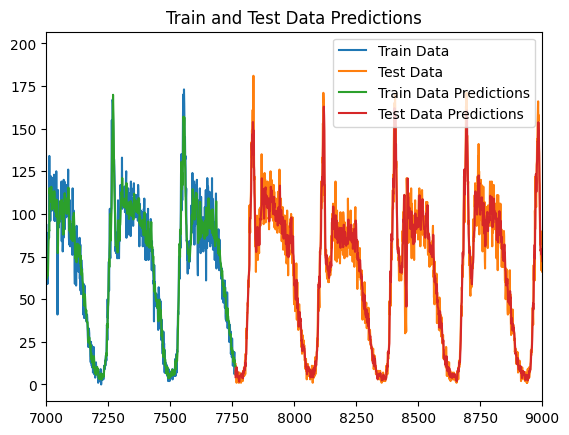

In [21]:
# Plot train and test data along with their predictions
plt.plot([x for x in range(len(train_original_normal))], list(train_original_normal), label='Train Data')
plt.plot([x for x in range(len(train_original_normal), len(train_original_normal) + len(test_original_normal))], list(test_original_normal), label='Test Data')
plt.plot([x for x in range(len(train_original_normal))], list(train_predictions_normal), label='Train Data Predictions')
plt.plot([x for x in range(len(train_original_normal), len(train_original_normal) + len(test_original_normal))], list(test_predictions_normal), label='Test Data Predictions')
plt.legend()
plt.title('Train and Test Data Predictions')
plt.xlim([7000, 9000])  # Set x-axis limits to focus on a specific range of data points

In [22]:
def calculate_mse(list1, list2):
    """
    Calculate the mean squared error (MSE) between two lists of elements.

    Args:
        list1 (list): First list of elements.
        list2 (list): Second list of elements.

    Returns:
        float: Mean squared error (MSE) between the two lists.
    """
    array1 = np.array(list1)
    array2 = np.array(list2)
    mse = np.mean((array1 - array2) ** 2)
    return mse

def calculate_mae(list1, list2):
    """
    Calculate the mean absolute error (MAE) between two lists of elements.

    Args:
        list1 (list): First list of elements.
        list2 (list): Second list of elements.

    Returns:
        float: Mean absolute error (MAE) between the two lists.
    """
    array1 = np.array(list1)
    array2 = np.array(list2)
    mae = np.mean(np.abs(array1 - array2))
    return mae

train_mse = calculate_mse(train_original_normal, train_predictions_normal)
test_mse = calculate_mse(test_original_normal, test_predictions_normal)
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

train_mae = calculate_mae(train_original_normal, train_predictions_normal)
test_mae = calculate_mae(test_original_normal, test_predictions_normal)
print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")

Train MSE: 95.8634602002282, Test MSE: 96.09182653427136
Train MAE: 7.202792336171906, Test MAE: 7.206861110855528


### Implementation of FedGRU

In [23]:
def federated_average(weights_list):
    """
    Perform federated averaging of model weights.

    Args:
        weights_list (list): List of dictionaries containing model weights.

    Returns:
        dict: A dictionary containing the averaged model weights.
    """
    # Deep copy the weights of the first model
    averaged_weights = deepcopy(weights_list[0])
    
    # Iterate over the keys of the model weights
    for key in averaged_weights.keys():
        # Sum up the corresponding weights from all models
        for i in range(1, len(weights_list)):
            averaged_weights[key] += weights_list[i][key]
        
        # Calculate the average by dividing by the number of models
        averaged_weights[key] = torch.div(averaged_weights[key], len(weights_list))
    
    return averaged_weights

class DatasetSplit(Dataset):
    """
    Custom PyTorch Dataset class for splitting a dataset based on given indices.

    Args:
        dataset (Dataset): The original dataset.
        idxs (list): List of indices to include in the split.
    """
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)  # Convert idxs to list for indexing

    def __len__(self):
        """
        Get the length of the dataset split.

        Returns:
            int: Length of the dataset split.
        """
        return len(self.idxs)

    def __getitem__(self, idx):
        """
        Get an item from the dataset split.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the data and label at the specified index.
        """
        # Return data and label at the specified index
        data, label = self.dataset[self.idxs[idx]]
        return data, label


In [24]:
def generate_iid_data_indices(dataset, num_users):
    """
    Generate indices for IID (independent and identically distributed) data partitioning.

    Args:
        dataset (list or torch.utils.data.Dataset): The dataset to partition.
        num_users (int): The number of users (clients) to generate data indices for.

    Returns:
        dict: A dictionary where keys are user IDs and values are sets of data indices.
    """
    num_items_per_user = int(len(dataset) / num_users)
    user_data_indices = {}  # Dictionary to store data indices for each user
    all_indices = [i for i in range(len(dataset))]  # List of all indices in the dataset

    # Iterate over the number of users to generate data indices for each user
    for user_id in range(num_users):
        # Randomly select indices for the current user without replacement
        user_data_indices[user_id] = set(np.random.choice(all_indices, num_items_per_user, replace=False))
        
        # Remove the selected indices from the list of all indices
        all_indices = list(set(all_indices) - user_data_indices[user_id])
    
    return user_data_indices

def generate_client_datasets(dataset, user_data_indices, batch_size=128):
    """
    Generate DataLoader objects for each client based on their data indices.

    Args:
        dataset (list or torch.utils.data.Dataset): The dataset to create client datasets from.
        user_data_indices (dict): A dictionary where keys are user IDs and values are sets of data indices.
        batch_size (int, optional): The batch size for DataLoader objects. Defaults to 128.

    Returns:
        dict: A dictionary where keys are user IDs and values are DataLoader objects for each client.
    """
    datasets = {}  # Dictionary to store DataLoader objects for each client
    for user_id in range(len(user_data_indices.keys())):
        # Create DataLoader for the current client's data using DatasetSplit
        datasets[user_id] = DataLoader(DatasetSplit(dataset, user_data_indices[user_id]), batch_size=batch_size, shuffle=True)

    return datasets


In [25]:
dataset_train = TensorDataset(X_train, y_train)

# Generate IID data indices for 5 users
indices = generate_iid_data_indices(dataset_train, 5)

# Generate mini datasets for each client based on the IID data indices
minidata = generate_client_datasets(dataset_train, indices)
minidata

# Iterate over the DataLoader of the first client's mini dataset
for _, (X_batch, y_batch) in enumerate(minidata[0]):
    # Print the shape of the batch and the first sample
    print(X_batch.shape, y_batch.shape)
    print("Sample Input:", X_batch[0])
    print("Sample Label:", y_batch[0])
    break


torch.Size([128, 12, 1]) torch.Size([128, 1])
Sample Input: tensor([[ 0.0152],
        [-0.0660],
        [-0.1168],
        [-0.1066],
        [ 0.1675],
        [-0.1269],
        [-0.1777],
        [-0.1066],
        [ 0.0964],
        [-0.1371],
        [-0.1066],
        [-0.1574]])
Sample Label: tensor([-0.1168])


In [26]:
# Define the number of users
USERS = 5

# Create TensorDataset objects for the training and testing data
dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)

# Generate IID data indices for the training dataset based on the number of users
indices = generate_iid_data_indices(dataset_train, USERS)

# Generate mini datasets for each client based on the IID data indices
user_data = generate_client_datasets(dataset_train, indices)
user_data


{0: <torch.utils.data.dataloader.DataLoader at 0x7faab426b990>,
 1: <torch.utils.data.dataloader.DataLoader at 0x7faab4303cd0>,
 2: <torch.utils.data.dataloader.DataLoader at 0x7faab427b950>,
 3: <torch.utils.data.dataloader.DataLoader at 0x7faab4286bd0>,
 4: <torch.utils.data.dataloader.DataLoader at 0x7faab4284a50>}

In [27]:
# Define the input, hidden, and output dimensions for the GRU model
input_num, hidden_num, output_num, num_layers = lag, 100, 1, 2  # Define the input, hidden, and output dimensions

# Instantiate the global GRU model and move it to the appropriate device
net_glob = GRU(input_num, hidden_num, output_num, num_layers).to(device)

# Display the instantiated global GRU model
net_glob


GRU(
  (gru_layers): ModuleList(
    (0): GRU(12, 100, batch_first=True)
    (1): GRU(100, 100, batch_first=True)
  )
  (output_linear): Linear(in_features=100, out_features=1, bias=True)
)

In [28]:
# Define whether all clients participate in training or only a fraction of them
all_clients_participate = False
fraction_of_clients_participating = 0.5  # Fraction of clients participating in training (between 0 and 1)
num_clients = USERS  # Total number of clients

total_main_epochs = 100  # Total number of main training epochs
total_local_epochs = 30  # Total number of local training epochs
local_batch_size = 256  # Local batch size for training on each client

local_model_weights = []  # List to store local model weights

# Determine which clients are participating based on the specified criteria
if all_clients_participate:
    # If all clients participate, initialize local model weights for each client
    local_model_weights = [net_glob.state_dict() for _ in range(num_clients)]
else:
    # If only a fraction of clients participate, randomly select participating clients
    num_participating_clients = max(int(fraction_of_clients_participating * num_clients), 1)  # Ensure at least 1 client participates
    participating_clients = np.random.choice(range(num_clients), num_participating_clients, replace=False)

# Display the participating clients
participating_clients


array([0, 1])

In [29]:
def Update_Local_Client(client_model_weights, client_data):
    """
    Perform local training on a client's data using a specified model.

    Args:
        client_model_weights (dict): Dictionary containing the weights of the client's model.
        client_data (DataLoader): DataLoader containing the client's data.

    Returns:
        tuple: A tuple containing the updated model weights and the average loss over local epochs.
    """
    # Initialize a new instance of the GRU model with the specified architecture
    client_model = GRU(input_num, hidden_num, output_num, num_layers).to(device)
    
    # Load the client's model weights
    client_model.load_state_dict(client_model_weights)
    
    # Set the model to training mode
    client_model.train()
    
    # Define the optimizer and loss function
    optimizer = torch.optim.Adam(client_model.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()
    
    local_epoch_loss = []  # List to store loss for each local epoch
    
    # Iterate over the specified number of local epochs
    for epoch in range(total_local_epochs):
        batch_loss = []  # List to store loss for each batch
        
        # Iterate over the batches of data in the client's DataLoader
        for batch_idx, (X_batch, y_batch) in enumerate(client_data):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
            optimizer.zero_grad()  # Zero gradients
            output, _ = client_model(X_batch)  # Forward pass
            output = output.squeeze(1)  # Squeeze the output tensor
            loss = loss_function(output, y_batch)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            batch_loss.append(loss.item())  # Append loss for the batch
        
        # Compute average loss for the epoch and append to the list
        local_epoch_loss.append(sum(batch_loss) / len(batch_loss))

    # Return the updated model weights and the average loss over local epochs
    return client_model.state_dict(), sum(local_epoch_loss) / len(local_epoch_loss)


++++++++++++++Main Epoch: 1++++++++++++++
Client: 0
Local Loss for Client 0: 0.018208021842516388
Client: 4
Local Loss for Client 4: 0.01708591134251597
Avg Local Loss over Clients: 0.01764696659251618
Average Test Loss: 0.15196349515634425
*********************************************
++++++++++++++Main Epoch: 2++++++++++++++
Client: 1
Local Loss for Client 1: 0.014678130343628047
Client: 4
Local Loss for Client 4: 0.013087593296017403
Avg Local Loss over Clients: 0.013882861819822725
Average Test Loss: 0.0686615880797891
*********************************************
++++++++++++++Main Epoch: 3++++++++++++++
Client: 4
Local Loss for Client 4: 0.010565390156056636
Client: 0
Local Loss for Client 0: 0.011557989943629273
Avg Local Loss over Clients: 0.011061690049842955
Average Test Loss: 0.02568067774614867
*********************************************
++++++++++++++Main Epoch: 4++++++++++++++
Client: 1
Local Loss for Client 1: 0.011239158973479881
Client: 2
Local Loss for Client 2: 0.0

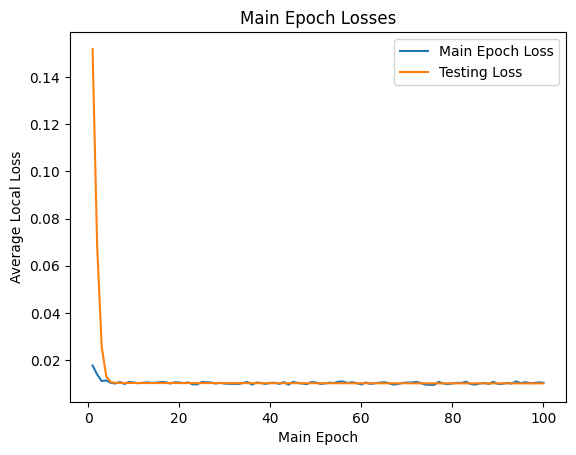

In [30]:
net_glob.train()
w_glob = net_glob.state_dict()

learning_rate = 0.001
loss_function = nn.MSELoss()

# Determine which clients are participating based on the specified criteria
if all_clients_participate:
    # If all clients participate, initialize local model weights for each client
    local_model_weights = [net_glob.state_dict() for _ in range(num_clients)]
else:
    # If only a fraction of clients participate, randomly select participating clients
    num_participating_clients = max(int(fraction_of_clients_participating * num_clients), 1)  # Ensure at least 1 client participates
    participating_clients = np.random.choice(range(num_clients), num_participating_clients, replace=False)

local_models = [w_glob for i in range(USERS)] 
main_epoch_losses = []
test_losses_GRU = []

for iter in range(total_main_epochs):
    print(f"++++++++++++++Main Epoch: {iter+1}++++++++++++++")
    total_avg_local_loss = 0

    for client in participating_clients:
        print(f"Client: {client}")
        
        local_glob, avg_local_loss = Update_Local_Client(local_models[client], user_data[client])
        print(f"Local Loss for Client {client}: {avg_local_loss}")

        if all_clients_participate:
            local_models[client] = deepcopy(local_glob)
        else:
            local_models.append(deepcopy(local_glob))
        
        total_avg_local_loss += avg_local_loss

    avg_local_loss_over_clients = total_avg_local_loss / len(participating_clients)
    print(f"Avg Local Loss over Clients: {avg_local_loss_over_clients}")
    main_epoch_losses.append(avg_local_loss_over_clients)

    w_glob = federated_average(local_models)
    net_glob.load_state_dict(w_glob)

    # Evaluation on the test set
    net_glob.eval()  # Set model to evaluation mode
    running_test_loss = 0
    
    with torch.no_grad():
        # Iterate over batches in the test data loader
        for batch_idx, (X_batch, y_batch) in enumerate(test_data_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output, _ = net_glob(X_batch)  # Use net_glob for evaluation
            output = output.squeeze(1)
            loss = loss_function(output, y_batch)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_data_loader)
    print(f"Average Test Loss: {avg_test_loss}")
    print("*********************************************")
    
    test_losses_GRU.append(avg_test_loss)  # Append testing loss for the epoch

    if all_clients_participate:
        # If all clients participate
        continue
    else:
        # If only a fraction of clients participate, randomly select participating clients
        num_participating_clients = max(int(fraction_of_clients_participating * num_clients), 1)  # Ensure at least 1 client participates
        participating_clients = np.random.choice(range(num_clients), num_participating_clients, replace=False)

# Plot the main epoch losses
plt.plot(range(1, total_main_epochs + 1), main_epoch_losses, label='Main Epoch Loss')
plt.plot(range(1, total_main_epochs + 1), test_losses_GRU, label='Testing Loss')
plt.xlabel('Main Epoch')
plt.ylabel('Average Local Loss')
plt.title('Main Epoch Losses')
plt.legend()
plt.show()


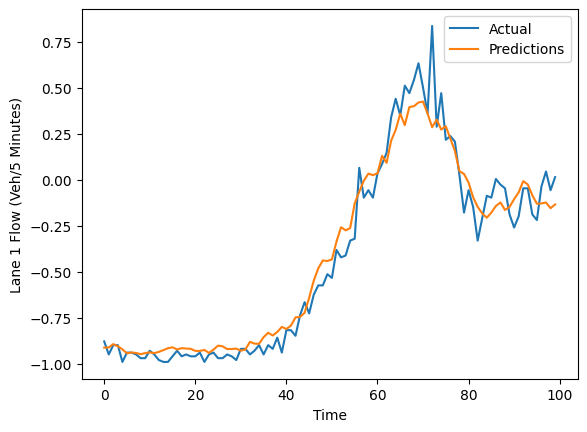

In [31]:
# Plotting predictions against actual values for a subset of data points
k = 100

# Generate predictions on the training data using the global model
with torch.no_grad():
    train_predictions_GRU = net_glob(X_train.to(device))[0].cpu().numpy()

# Plot actual and predicted values for the first k data points
plt.plot(y_test[:k], label="Actual")
plt.plot(train_predictions_GRU.squeeze()[:k], label='Predictions')
plt.xlabel('Time')
plt.ylabel('Lane 1 Flow (Veh/5 Minutes)')
plt.legend()
plt.show()


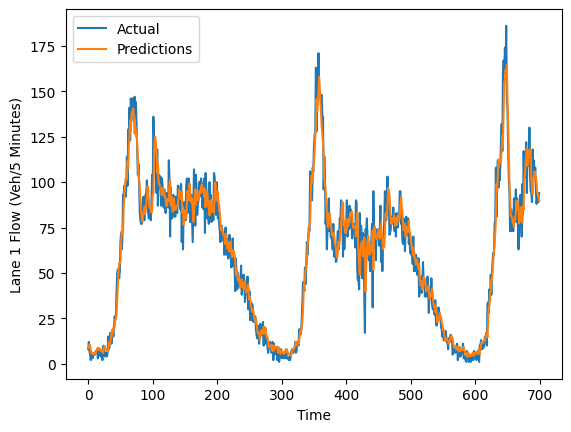

In [32]:
# Flatten the train predictions
train_predictions_normal_GRU = train_predictions_GRU.flatten()

# Invert transform the train predictions
dummies = np.zeros((X_train.shape[0], lag+1))
dummies[:,0] = train_predictions_normal_GRU
dummies = scaler.inverse_transform(dummies)
train_predictions_normal_GRU = deepcopy(dummies[:,0])

# Invert transform the original train data
dummies = np.zeros((X_train.shape[0], lag+1))
dummies[:,0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)
train_original_normal = deepcopy(dummies[:,0])

# Plot actual and predicted values for a subset of the data
k = 700
plt.plot(train_original_normal[:k], label="Actual")
plt.plot(train_predictions_normal_GRU.squeeze()[:k], label='Predictions')
plt.xlabel('Time')
plt.ylabel('Lane 1 Flow (Veh/5 Minutes)')
plt.legend()
plt.show()


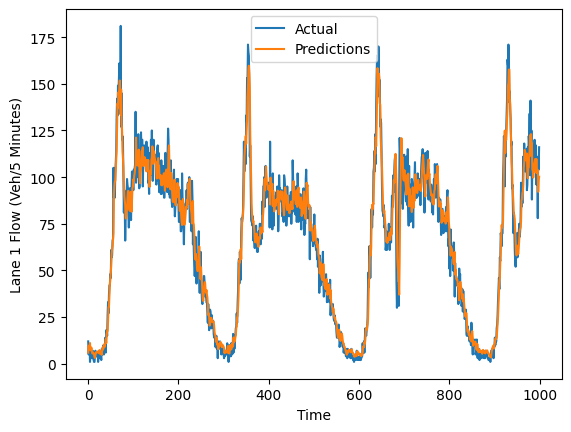

In [33]:
# Get the test predictions
test_predictions_GRU = net_glob(X_test.to(device))[0].detach().cpu().numpy().flatten()

# Invert transform the test predictions
dummies = np.zeros((X_test.shape[0], lag+1))
dummies[:,0] = test_predictions_GRU
dummies = scaler.inverse_transform(dummies)
test_predictions_normal_GRU = deepcopy(dummies[:,0])

# Invert transform the original test data
dummies = np.zeros((X_test.shape[0], lag+1))
dummies[:,0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
test_original_normal = deepcopy(dummies[:,0])

# Plot actual and predicted values for a subset of the test data
k = 1000
plt.plot(test_original_normal[:k], label="Actual")
plt.plot(test_predictions_normal_GRU.squeeze()[:k], label='Predictions')
plt.xlabel('Time')
plt.ylabel('Lane 1 Flow (Veh/5 Minutes)')
plt.legend()
plt.show()


(7000.0, 9000.0)

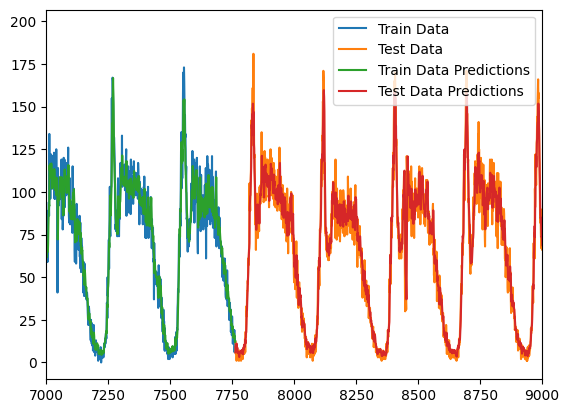

In [34]:
# Plot the train and test data along with their predictions
plt.plot([x for x in range(len(train_original_normal))], list(train_original_normal), label='Train Data')
plt.plot([x for x in range(len(train_original_normal), len(train_original_normal) + len(test_original_normal))], list(test_original_normal), label='Test Data')

plt.plot([x for x in range(len(train_original_normal))], list(train_predictions_normal_GRU), label='Train Data Predictions')
plt.plot([x for x in range(len(train_original_normal), len(train_original_normal) + len(test_original_normal))], list(test_predictions_normal_GRU), label='Test Data Predictions')

plt.legend()
plt.xlim([7000, 9000])  # Set x-axis limit


In [35]:
def calculate_mse(list1, list2):
    """
    Calculate the mean squared error (MSE) between two lists of elements.

    Args:
        list1 (list): First list of elements.
        list2 (list): Second list of elements.

    Returns:
        float: Mean squared error (MSE) between the two lists.
    """
    array1 = np.array(list1)
    array2 = np.array(list2)
    mse = np.mean((array1 - array2) ** 2)
    return mse

def calculate_mae(list1, list2):
    """
    Calculate the mean absolute error (MAE) between two lists of elements.

    Args:
        list1 (list): First list of elements.
        list2 (list): Second list of elements.

    Returns:
        float: Mean absolute error (MAE) between the two lists.
    """
    array1 = np.array(list1)
    array2 = np.array(list2)
    mae = np.mean(np.abs(array1 - array2))
    return mae

# Calculate MSE and MAE for train and test predictions
train_mse = calculate_mse(train_original_normal, train_predictions_normal_GRU)
test_mse = calculate_mse(test_original_normal, test_predictions_normal_GRU)
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

train_mae = calculate_mae(train_original_normal, train_predictions_normal_GRU)
test_mae = calculate_mae(test_original_normal, test_predictions_normal_GRU)
print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")


Train MSE: 98.30068675832699, Test MSE: 97.71862439846223
Train MAE: 7.331271916507332, Test MAE: 7.298130417134556


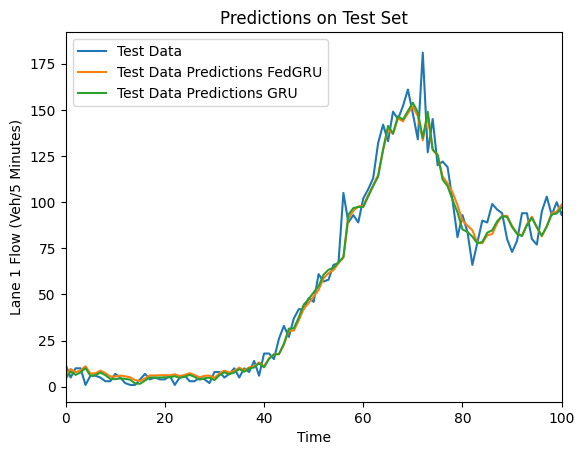

In [47]:
plt.plot([x for x in range(len(test_original_normal))], list(test_original_normal), label='Test Data')
plt.plot([x for x in range(len(test_original_normal))], list(test_predictions_normal_GRU), label='Test Data Predictions FedGRU')
plt.plot([x for x in range(len(test_original_normal))], list(test_predictions_normal), label='Test Data Predictions GRU')
plt.legend()
plt.xlim([0, 100])  # Set x-axis limit
plt.xlabel('Time')
plt.title('Predictions on Test Set')
plt.ylabel(f'{attr}')
plt.show()

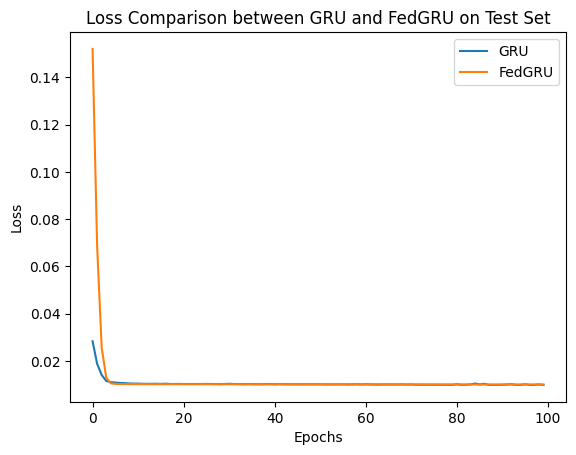

In [48]:
plt.plot([x for x in range(total_main_epochs)], test_losses, label='GRU')
plt.plot([x for x in range(total_main_epochs)], test_losses_GRU, label='FedGRU')
plt.xlabel('Epochs')
plt.ylabel(f'Loss')
plt.title("Loss Comparison between GRU and FedGRU on Test Set")
plt.legend()
plt.show()

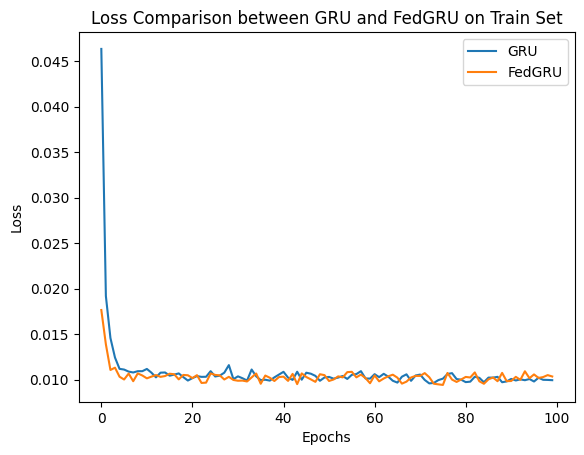

In [49]:
plt.plot([x for x in range(total_main_epochs)], train_losses, label='GRU')
plt.plot([x for x in range(total_main_epochs)], main_epoch_losses, label='FedGRU')
plt.xlabel('Epochs')
plt.ylabel(f'Loss')
plt.title("Loss Comparison between GRU and FedGRU on Train Set")
plt.legend()
plt.show()